## Importing Libraries

In [1]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb

/var/folders/kj/lxfx5ktx5fzdl5w_3ty2z5m00000gn/T/ipykernel_35970/760736020.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Loading the Cleaned and Not Label Encoded Traning Data

In [2]:
train_data_df = pd.read_csv("./cleaned_unencoded_training_data.csv")

In [3]:
train_data_df.shape

(351648, 30)

In [4]:
train_data_df.head()

,Quote,Segment,Order_Dt,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,...,Ship_lead_tm,ATA,Delay,System_updated_accuracy,System_accuracy,Ship_tm,Order_Dt_Month,Order_Dt_Week_Day,Order_Dt_Year_Day,ID
0,NaN,c3976246348c686e4deca0a7e331a039,2019-03-24,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,62eb42063b4c63d18f476e5c92eafa50,2384e716112fd9418cbb48957c45bfc5,652f6b0c37563fb728f0560faac1c036,30.0,10,...,5.0,26,-33,10,-23,10.0,3,6,83,0
1,1.017820e+12,d8856a306e76cdec5c33ddb4195c185d,2018-10-12,f7127745295f48bdf8fe7a38516d6d41,8fefe421a574b35a71a59d7334dc9d77,ecfc435e2f1b34807f368797625785a6,40871108ac50c36ac78ef67273d247e8,aceb0e7297d4bd8f4a1f0a8cbd2be3d9,5.0,1,...,6.0,10,-14,1,-13,1.0,10,4,285,1
2,3.000090e+12,c3976246348c686e4deca0a7e331a039,2019-02-23,7d2d85b3d683840d2b6ca6eb2ca1ba0c,2ce9e0196a21cf2045c0bec59f692a5f,e0975410aeac093508e12d41f3a2bd44,2384e716112fd9418cbb48957c45bfc5,3da37128be279acdc5f6843977bdaec6,30.0,2,...,4.0,33,-16,-1,-17,3.0,2,5,54,2
3,1.029690e+12,62ec0553902c09a0651064e81375217d,2019-02-05,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,8de35dfb7f96b0c4228dd9bfe4abf7aa,2384e716112fd9418cbb48957c45bfc5,19c7bb068de1fdffcb13cd2691e6088a,30.0,1,...,13.0,24,-29,4,-25,4.0,2,1,36,3
4,3.000080e+12,79238f4ec268203867a0d6847b3c2846,2019-01-08,68648ccd3ba6a5cb996019622a58c56e,5400e26de9b23978b8907afdcd0bcb97,b956dc64ac02f753e7549bbc660c74de,89bc8c0c87b49d3bb6f8fdb4b9bae4b0,3da37128be279acdc5f6843977bdaec6,46.0,2,...,9.0,108,28,6,34,8.0,1,1,8,4


## Loading Test Data

In [5]:
test_data_df = pd.read_csv("./data/Test.csv")

## Dropping Products with only one order because of train val split we need atleast proudcts with 2 orders

In [6]:
product_count = train_data_df["Product"].value_counts().reset_index()

In [7]:
product_count.loc[product_count['count'] == 1]

,Product,count
76,6ce6e5dbacca7b57944213312a676272,1


In [8]:
index_to_drop = train_data_df[train_data_df['Product'] == '6ce6e5dbacca7b57944213312a676272'].index

In [9]:
index_to_drop

Index([62119], dtype='int64')

In [10]:
train_data_df.drop(index=index_to_drop, inplace=True)

## Train Validation Split

In [11]:
only_train_data_df, val_data_df = train_test_split(train_data_df, test_size=0.2, shuffle=True, random_state=42, stratify=train_data_df['Product'])

In [12]:
only_train_data_df.to_csv("./only_train_data.csv", index=False)

In [13]:
val_data_df.to_csv("./val_data.csv", index=False)

## Getting Required Data

In [14]:
req_cols = ["ID", "Brand", "Product", "Ship_City", "Ship_state", "Segment", "Paym_term", "sku_lead_tm", "Qty", "order_amt", "prvlg_ship_mode", "prvlg_build_fac", "prvlg_ship_fac", 
            "diff_in_order_amt_and_quote", "Ship_lead_tm", "Delay", "Ship_tm", "Order_Dt_Month", "Order_Dt_Week_Day", "Order_Dt_Year_Day"]

In [15]:
req_train_data_df = train_data_df[req_cols]

In [16]:
req_train_data_df.shape

(351647, 20)

In [17]:
req_train_data_df.columns

Index(['ID', 'Brand', 'Product', 'Ship_City', 'Ship_state', 'Segment',
       'Paym_term', 'sku_lead_tm', 'Qty', 'order_amt', 'prvlg_ship_mode',
       'prvlg_build_fac', 'prvlg_ship_fac', 'diff_in_order_amt_and_quote',
       'Ship_lead_tm', 'Delay', 'Ship_tm', 'Order_Dt_Month',
       'Order_Dt_Week_Day', 'Order_Dt_Year_Day'],
      dtype='object')

In [18]:
req_train_data_df.isna().sum()

ID                                 0
Brand                              0
Product                            0
Ship_City                          0
Ship_state                         0
Segment                            0
Paym_term                          0
sku_lead_tm                    17170
Qty                                0
order_amt                          0
prvlg_ship_mode                    0
prvlg_build_fac                    0
prvlg_ship_fac                     0
diff_in_order_amt_and_quote        0
Ship_lead_tm                      11
Delay                              0
Ship_tm                            0
Order_Dt_Month                     0
Order_Dt_Week_Day                  0
Order_Dt_Year_Day                  0
dtype: int64

## Feature Engineering for Build and Ship Facilities

In [19]:
req_train_data_df["is_same_build_ship_fac"] = req_train_data_df["prvlg_build_fac"] == req_train_data_df["prvlg_ship_fac"]

/var/folders/kj/lxfx5ktx5fzdl5w_3ty2z5m00000gn/T/ipykernel_35970/3574961785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req_train_data_df["is_same_build_ship_fac"] = req_train_data_df["prvlg_build_fac"] == req_train_data_df["prvlg_ship_fac"]


In [20]:
req_train_data_df["is_same_build_ship_fac"].value_counts()

is_same_build_ship_fac
True     269594
False     82053
Name: count, dtype: int64

In [21]:
req_train_data_df["is_same_build_ship_fac"] = req_train_data_df["is_same_build_ship_fac"].apply(lambda x: 1 if x == True else 0)

/var/folders/kj/lxfx5ktx5fzdl5w_3ty2z5m00000gn/T/ipykernel_35970/507999715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req_train_data_df["is_same_build_ship_fac"] = req_train_data_df["is_same_build_ship_fac"].apply(lambda x: 1 if x == True else 0)


In [22]:
req_train_data_df["is_same_build_ship_fac"].value_counts()

is_same_build_ship_fac
1    269594
0     82053
Name: count, dtype: int64

In [23]:
req_train_data_df.isna().sum()

ID                                 0
Brand                              0
Product                            0
Ship_City                          0
Ship_state                         0
Segment                            0
Paym_term                          0
sku_lead_tm                    17170
Qty                                0
order_amt                          0
prvlg_ship_mode                    0
prvlg_build_fac                    0
prvlg_ship_fac                     0
diff_in_order_amt_and_quote        0
Ship_lead_tm                      11
Delay                              0
Ship_tm                            0
Order_Dt_Month                     0
Order_Dt_Week_Day                  0
Order_Dt_Year_Day                  0
is_same_build_ship_fac             0
dtype: int64

## Imputing 11 Null Values for Ship Lead Time with the Median of Ship Lead Time

In [24]:
req_train_data_df["Ship_lead_tm"].fillna(req_train_data_df["Ship_lead_tm"].median(), inplace=True)

/var/folders/kj/lxfx5ktx5fzdl5w_3ty2z5m00000gn/T/ipykernel_35970/1591921445.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  req_train_data_df["Ship_lead_tm"].fillna(req_train_data_df["Ship_lead_tm"].median(), inplace=True)
/var/folders/kj/lxfx5ktx5fzdl5w_3ty2z5m00000gn/T/ipykernel_35970/1591921445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [25]:
req_train_data_df.isna().sum()

ID                                 0
Brand                              0
Product                            0
Ship_City                          0
Ship_state                         0
Segment                            0
Paym_term                          0
sku_lead_tm                    17170
Qty                                0
order_amt                          0
prvlg_ship_mode                    0
prvlg_build_fac                    0
prvlg_ship_fac                     0
diff_in_order_amt_and_quote        0
Ship_lead_tm                       0
Delay                              0
Ship_tm                            0
Order_Dt_Month                     0
Order_Dt_Week_Day                  0
Order_Dt_Year_Day                  0
is_same_build_ship_fac             0
dtype: int64

In [26]:
X = req_train_data_df.drop(columns=["Ship_tm", "Ship_lead_tm"])
Y_total_ship_time = req_train_data_df["Ship_tm"] + req_train_data_df["Ship_lead_tm"]
Y_ship_time = req_train_data_df["Ship_tm"]

In [27]:
Y_ship_time.isna().sum()

0

In [28]:
Y_total_ship_time.isna().sum()

0

In [29]:
X.shape

(351647, 19)

In [30]:
Y_total_ship_time = Y_total_ship_time.reset_index(name="Ship_tm + Ship_lead_tm")

In [31]:
X["ID"].isna().sum()

0

In [32]:
Y_total_ship_time['index'] = X["ID"].values

In [33]:
Y_ship_time = Y_ship_time.reset_index(name="Ship_tm")

In [34]:
Y_ship_time.isna().sum()

index      0
Ship_tm    0
dtype: int64

In [35]:
Y_ship_time.shape

(351647, 2)

In [36]:
X.shape

(351647, 19)

In [37]:
Y_ship_time["index"] = X["ID"].values

In [38]:
Y_ship_time.isna().sum()

index      0
Ship_tm    0
dtype: int64

In [39]:
Y_total_ship_time.head()

,index,Ship_tm + Ship_lead_tm
0,0,15.0
1,1,7.0
2,2,7.0
3,3,17.0
4,4,17.0


In [40]:
Y_total_ship_time.rename(columns={"index": "ID"}, inplace=True)

In [41]:
Y_ship_time.rename(columns={"index": "ID"}, inplace=True)

In [42]:
Y_ship_time.isna().sum()

ID         0
Ship_tm    0
dtype: int64

## Separating the Validation and Training Data from total Data

In [43]:
only_train_index = only_train_data_df["ID"].values

In [44]:
val_index = val_data_df["ID"].values

In [45]:
X_train = X[X["ID"].isin(only_train_index)].copy()
X_val = X[X["ID"].isin(val_index)].copy()
y_train_total_ship_time = Y_total_ship_time.loc[Y_total_ship_time["ID"].isin(only_train_index), "Ship_tm + Ship_lead_tm"].copy()
y_val_total_ship_time = Y_total_ship_time.loc[Y_total_ship_time["ID"].isin(val_index), "Ship_tm + Ship_lead_tm"].copy()
y_train_ship_time = Y_ship_time.loc[Y_ship_time["ID"].isin(only_train_index), "Ship_tm"].copy()
y_val_ship_time = Y_ship_time.loc[Y_ship_time["ID"].isin(val_index), "Ship_tm"].copy()
X_train.drop(columns=["ID"], inplace=True)
X_val.drop(columns=["ID"], inplace=True)

In [46]:
y_train_ship_time.dropna(inplace=True)

In [47]:
y_train_ship_time.isna().sum()

0

In [48]:
X_train.shape

(281317, 18)

In [49]:
X_val.shape

(70330, 18)

In [50]:
X_train.isna().sum()

Brand                              0
Product                            0
Ship_City                          0
Ship_state                         0
Segment                            0
Paym_term                          0
sku_lead_tm                    13732
Qty                                0
order_amt                          0
prvlg_ship_mode                    0
prvlg_build_fac                    0
prvlg_ship_fac                     0
diff_in_order_amt_and_quote        0
Delay                              0
Order_Dt_Month                     0
Order_Dt_Week_Day                  0
Order_Dt_Year_Day                  0
is_same_build_ship_fac             0
dtype: int64

In [51]:
X_val.isna().sum()

Brand                             0
Product                           0
Ship_City                         0
Ship_state                        0
Segment                           0
Paym_term                         0
sku_lead_tm                    3438
Qty                               0
order_amt                         0
prvlg_ship_mode                   0
prvlg_build_fac                   0
prvlg_ship_fac                    0
diff_in_order_amt_and_quote       0
Delay                             0
Order_Dt_Month                    0
Order_Dt_Week_Day                 0
Order_Dt_Year_Day                 0
is_same_build_ship_fac            0
dtype: int64

## Defining Outlier Removal class using IQR Method

In [52]:
X["Delay"].describe()

count    351647.000000
mean         -7.830964
std          25.232340
min        -118.000000
25%         -20.000000
50%          -9.000000
75%           0.000000
max        4131.000000
Name: Delay, dtype: float64

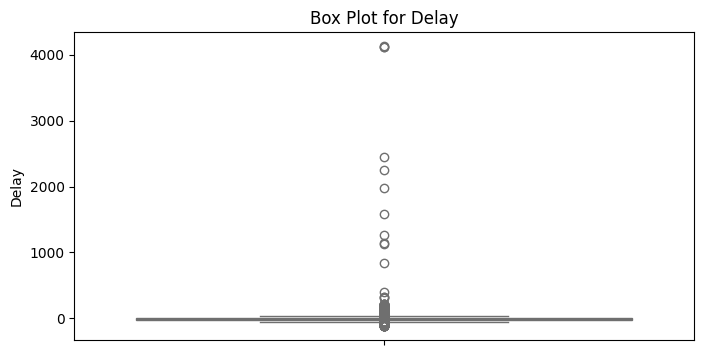

In [53]:
plt.figure(figsize=(8, 4))
sns.boxplot(y='Delay', data=X, color='skyblue', showfliers=True)

# Customize the plot
plt.title('Box Plot for Delay')
plt.ylabel('Delay')

# Show the plot
plt.show()

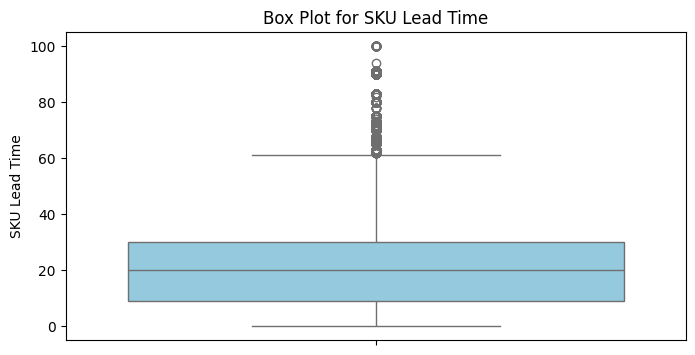

In [54]:
plt.figure(figsize=(8, 4))
sns.boxplot(y='sku_lead_tm', data=X, color='skyblue', showfliers=True)

# Customize the plot
plt.title('Box Plot for SKU Lead Time')
plt.ylabel('SKU Lead Time')


# Show the plot
plt.show()

In [55]:
class IQRTransformer:
    def __init__(self, columns, data):
        self.columns = columns
        self.data = data

    def fit(self):
        self.lower_bounds = {}
        self.upper_bounds = {}
        for col in self.columns:
            Q1 = self.data[col].quantile(0.25)
            Q3 = self.data[col].quantile(0.75)
            IQR = Q3 - Q1
            self.lower_bounds[col] = Q1 - 1.5 * IQR
            self.upper_bounds[col] = Q3 + 1.5 * IQR
        print(f"Lower Bounds are: {self.lower_bounds}")
        print(f"Upper Bounds are: {self.upper_bounds}")

    def transform(self):
        for col in self.columns:
            self.data = self.data.loc[(self.data[col] >= self.lower_bounds[col]) & (self.data[col] <= self.upper_bounds[col])].copy()
        return self.data

In [56]:
columns_to_apply_iqr = ["sku_lead_tm", "Delay"] 

In [57]:
ship_tm_train_data_df = pd.concat([X_train.reset_index(drop=True), y_train_ship_time.reset_index(drop=True)], axis=1)
ship_tm_train_data_df.rename(columns={0: "Ship_tm"}, inplace=True)
ship_tm_train_data_df.head()

,Brand,Product,Ship_City,Ship_state,Segment,Paym_term,sku_lead_tm,Qty,order_amt,prvlg_ship_mode,prvlg_build_fac,prvlg_ship_fac,diff_in_order_amt_and_quote,Delay,Order_Dt_Month,Order_Dt_Week_Day,Order_Dt_Year_Day,is_same_build_ship_fac,Ship_tm
0,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,62eb42063b4c63d18f476e5c92eafa50,2384e716112fd9418cbb48957c45bfc5,c3976246348c686e4deca0a7e331a039,652f6b0c37563fb728f0560faac1c036,30.0,10,8448.009347,8c99a6e96b1e636675d6d71eeabd5938,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,0.000000e+00,-33,3,6,83,1,10.0
1,7d2d85b3d683840d2b6ca6eb2ca1ba0c,2ce9e0196a21cf2045c0bec59f692a5f,e0975410aeac093508e12d41f3a2bd44,2384e716112fd9418cbb48957c45bfc5,c3976246348c686e4deca0a7e331a039,3da37128be279acdc5f6843977bdaec6,30.0,2,1142.849799,8c99a6e96b1e636675d6d71eeabd5938,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,-3.000090e+12,-16,2,5,54,1,3.0
2,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,8de35dfb7f96b0c4228dd9bfe4abf7aa,2384e716112fd9418cbb48957c45bfc5,62ec0553902c09a0651064e81375217d,19c7bb068de1fdffcb13cd2691e6088a,30.0,1,1574.382299,8c99a6e96b1e636675d6d71eeabd5938,334dfb1ef5fc623374b835e11383d8a0,82f1724d93a668a5800a91973e3115f2,-1.029690e+12,-29,2,1,36,0,4.0
3,68648ccd3ba6a5cb996019622a58c56e,5400e26de9b23978b8907afdcd0bcb97,b956dc64ac02f753e7549bbc660c74de,89bc8c0c87b49d3bb6f8fdb4b9bae4b0,79238f4ec268203867a0d6847b3c2846,3da37128be279acdc5f6843977bdaec6,46.0,2,1285.218528,57dcf6017ed4410f481220ec1e135c81,c9f6ff0d507cbe7ca0ea07e4c88a1880,c9f6ff0d507cbe7ca0ea07e4c88a1880,-3.000080e+12,28,1,1,8,1,8.0
4,7d2d85b3d683840d2b6ca6eb2ca1ba0c,2ce9e0196a21cf2045c0bec59f692a5f,d3401975cd4f6464acc9d7f2d2000d39,51781a12f1a03484cb2455108a9740db,c3976246348c686e4deca0a7e331a039,652f6b0c37563fb728f0560faac1c036,35.0,2,1068.164072,8c99a6e96b1e636675d6d71eeabd5938,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,-1.022860e+12,-1,2,5,33,1,1.0


In [58]:
ship_tm_train_data_df.isna().sum()

Brand                              0
Product                            0
Ship_City                          0
Ship_state                         0
Segment                            0
Paym_term                          0
sku_lead_tm                    13732
Qty                                0
order_amt                          0
prvlg_ship_mode                    0
prvlg_build_fac                    0
prvlg_ship_fac                     0
diff_in_order_amt_and_quote        0
Delay                              0
Order_Dt_Month                     0
Order_Dt_Week_Day                  0
Order_Dt_Year_Day                  0
is_same_build_ship_fac             0
Ship_tm                            0
dtype: int64

In [59]:
total_ship_tm_train_data_df = pd.concat([X_train.reset_index(drop=True), y_train_total_ship_time.reset_index(drop=True)], axis=1)
total_ship_tm_train_data_df.rename(columns={0: "Ship_tm + Ship_lead_tm"}, inplace=True)
total_ship_tm_train_data_df.head()

,Brand,Product,Ship_City,Ship_state,Segment,Paym_term,sku_lead_tm,Qty,order_amt,prvlg_ship_mode,prvlg_build_fac,prvlg_ship_fac,diff_in_order_amt_and_quote,Delay,Order_Dt_Month,Order_Dt_Week_Day,Order_Dt_Year_Day,is_same_build_ship_fac,Ship_tm + Ship_lead_tm
0,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,62eb42063b4c63d18f476e5c92eafa50,2384e716112fd9418cbb48957c45bfc5,c3976246348c686e4deca0a7e331a039,652f6b0c37563fb728f0560faac1c036,30.0,10,8448.009347,8c99a6e96b1e636675d6d71eeabd5938,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,0.000000e+00,-33,3,6,83,1,15.0
1,7d2d85b3d683840d2b6ca6eb2ca1ba0c,2ce9e0196a21cf2045c0bec59f692a5f,e0975410aeac093508e12d41f3a2bd44,2384e716112fd9418cbb48957c45bfc5,c3976246348c686e4deca0a7e331a039,3da37128be279acdc5f6843977bdaec6,30.0,2,1142.849799,8c99a6e96b1e636675d6d71eeabd5938,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,-3.000090e+12,-16,2,5,54,1,7.0
2,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,8de35dfb7f96b0c4228dd9bfe4abf7aa,2384e716112fd9418cbb48957c45bfc5,62ec0553902c09a0651064e81375217d,19c7bb068de1fdffcb13cd2691e6088a,30.0,1,1574.382299,8c99a6e96b1e636675d6d71eeabd5938,334dfb1ef5fc623374b835e11383d8a0,82f1724d93a668a5800a91973e3115f2,-1.029690e+12,-29,2,1,36,0,17.0
3,68648ccd3ba6a5cb996019622a58c56e,5400e26de9b23978b8907afdcd0bcb97,b956dc64ac02f753e7549bbc660c74de,89bc8c0c87b49d3bb6f8fdb4b9bae4b0,79238f4ec268203867a0d6847b3c2846,3da37128be279acdc5f6843977bdaec6,46.0,2,1285.218528,57dcf6017ed4410f481220ec1e135c81,c9f6ff0d507cbe7ca0ea07e4c88a1880,c9f6ff0d507cbe7ca0ea07e4c88a1880,-3.000080e+12,28,1,1,8,1,17.0
4,7d2d85b3d683840d2b6ca6eb2ca1ba0c,2ce9e0196a21cf2045c0bec59f692a5f,d3401975cd4f6464acc9d7f2d2000d39,51781a12f1a03484cb2455108a9740db,c3976246348c686e4deca0a7e331a039,652f6b0c37563fb728f0560faac1c036,35.0,2,1068.164072,8c99a6e96b1e636675d6d71eeabd5938,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,-1.022860e+12,-1,2,5,33,1,7.0


In [60]:
total_ship_tm_train_data_df.isna().sum()

Brand                              0
Product                            0
Ship_City                          0
Ship_state                         0
Segment                            0
Paym_term                          0
sku_lead_tm                    13732
Qty                                0
order_amt                          0
prvlg_ship_mode                    0
prvlg_build_fac                    0
prvlg_ship_fac                     0
diff_in_order_amt_and_quote        0
Delay                              0
Order_Dt_Month                     0
Order_Dt_Week_Day                  0
Order_Dt_Year_Day                  0
is_same_build_ship_fac             0
Ship_tm + Ship_lead_tm             0
dtype: int64

In [61]:
iqr_ship_tm_data = IQRTransformer(columns=columns_to_apply_iqr, data=ship_tm_train_data_df)
iqr_ship_tm_data.fit()


Lower Bounds are: {'sku_lead_tm': -22.5, 'Delay': -50.0}
Upper Bounds are: {'sku_lead_tm': 61.5, 'Delay': 30.0}


In [62]:
ship_tm_train_data_df.shape

(281317, 19)

In [63]:
filtered_ship_tm_train_data_df = iqr_ship_tm_data.transform()

In [64]:
filtered_ship_tm_train_data_df.shape[0] / ship_tm_train_data_df.shape[0] * 100

87.47036261583906

## 12.3% of the Outlier observations have been removed from the training data

In [65]:
iqr_total_ship_tm_data = IQRTransformer(columns=columns_to_apply_iqr, data=total_ship_tm_train_data_df)
iqr_total_ship_tm_data.fit()


Lower Bounds are: {'sku_lead_tm': -22.5, 'Delay': -50.0}
Upper Bounds are: {'sku_lead_tm': 61.5, 'Delay': 30.0}


In [66]:
total_ship_tm_train_data_df.shape

(281317, 19)

In [67]:
filtered_total_ship_tm_train_data_df = iqr_total_ship_tm_data.transform()

In [68]:
filtered_total_ship_tm_train_data_df.shape[0] / total_ship_tm_train_data_df.shape[0] * 100

87.47036261583906

In [69]:
X_train =  filtered_ship_tm_train_data_df.drop(columns=["Ship_tm"])
y_train_ship_time = filtered_ship_tm_train_data_df["Ship_tm"]
y_train_total_ship_time = filtered_total_ship_tm_train_data_df["Ship_tm + Ship_lead_tm"]

In [70]:
X_train.shape

(246069, 18)

In [71]:
X_val.shape

(70330, 18)

In [72]:
y_train_ship_time

0         10.0
1          3.0
2          4.0
3          8.0
4          1.0
          ... 
281311     1.0
281313     4.0
281314     4.0
281315     4.0
281316     4.0
Name: Ship_tm, Length: 246069, dtype: float64

## Search Parameters for Hypreparameter Tuning

In [73]:
params_rf = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [10, 100, 500],
    'regressor__min_samples_leaf': [10, 100, 500],
}
params_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 2]
}

## Creating Sklearn Pipeline for Ship_tm + Ship_lead_tm

In [74]:
apex_categorical_cols = ['Brand',
 'Product',
 'Paym_term',
 'Ship_City',
 'Ship_state',
 'prvlg_ship_mode',
 'prvlg_build_fac',
 'prvlg_ship_fac',
 'Segment']

In [75]:
def training_pipeline_random_forest(numerical_features, categorical_features):

    numeric_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=10, random_state=42, max_depth=10, min_samples_leaf=500, min_samples_split=100))
    ])
    return pipeline

In [76]:
def training_pipeline_xgboost(numerical_features, categorical_features):

    numeric_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor('reg:squarederror', random_state=42))
    ])
    return pipeline

In [77]:
apex_numerical_cols = list(set(X_train.columns) - set(apex_categorical_cols))
rf_pipeline_apex_ship_time = training_pipeline_random_forest(apex_numerical_cols, apex_categorical_cols)
rf_pipeline_apex_total_ship_time = training_pipeline_random_forest(apex_numerical_cols, apex_categorical_cols)
xgb_pipeline_apex_ship_time = training_pipeline_xgboost(apex_numerical_cols, apex_numerical_cols)
xgb_pipeline_apex_total_ship_time = training_pipeline_xgboost(apex_numerical_cols, apex_numerical_cols)

/Users/priyanshutuli/Desktop/Dell_Usecase/.venv/lib/python3.12/site-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


In [78]:
rf_pipeline_apex_ship_time.fit(X_train, y_train_ship_time)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sku_lead_tm', 'Delay',
                                                   'Order_Dt_Week_Day',
                                                   'order_amt',
                                                   'diff_in_order_amt_and_quote',
                                                   'is_same_build_ship_fac',
                                                   'Qty', 'Order_Dt_Year_Day',
                                                   'Order_Dt_Month']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'Product',
                                                   'Paym_term', 'Ship_City',
                                                   'Ship_state',
                                                   'prvlg_ship_mode',
                                                   'prvlg_build_fac',
                                                   'prvlg_ship_fac',
                                                   'Segment'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=500,
                                       min_samples_split=100, n_estimators=10,
                                       random_state=42))])

In [79]:
rf_pipeline_apex_total_ship_time.fit(X_train, y_train_total_ship_time)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sku_lead_tm', 'Delay',
                                                   'Order_Dt_Week_Day',
                                                   'order_amt',
                                                   'diff_in_order_amt_and_quote',
                                                   'is_same_build_ship_fac',
                                                   'Qty', 'Order_Dt_Year_Day',
                                                   'Order_Dt_Month']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'Product',
                                                   'Paym_term', 'Ship_City',
                                                   'Ship_state',
                                                   'prvlg_ship_mode',
                                                   'prvlg_build_fac',
                                                   'prvlg_ship_fac',
                                                   'Segment'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=500,
                                       min_samples_split=100, n_estimators=10,
                                       random_state=42))])

In [80]:
xgb_pipeline_apex_ship_time.fit(X_train, y_train_ship_time)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sku_lead_tm', 'Delay',
                                                   'Order_Dt_Week_Day',
                                                   'order_amt',
                                                   'diff_in_order_amt_and_quote',
                                                   'is_same_build_ship_fac',
                                                   'Qty', 'Order_Dt_Year_Day',
                                                   'Order_Dt_Month']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   O...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [81]:
xgb_pipeline_apex_total_ship_time.fit(X_train, y_train_total_ship_time)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sku_lead_tm', 'Delay',
                                                   'Order_Dt_Week_Day',
                                                   'order_amt',
                                                   'diff_in_order_amt_and_quote',
                                                   'is_same_build_ship_fac',
                                                   'Qty', 'Order_Dt_Year_Day',
                                                   'Order_Dt_Month']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   O...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [82]:
random_search_rf = RandomizedSearchCV(rf_pipeline_apex_ship_time, param_distributions=params_rf, scoring='neg_mean_squared_error', n_jobs=-1, refit=True, cv=3,
                                      n_iter=3
                           )

## Hyperparameter Turning

In [83]:
rf_pipeline_apex_ship_time.score(X_val, y_val_ship_time)

0.2612221243802213

In [84]:
rf_pipeline_apex_total_ship_time.score(X_val, y_val_total_ship_time)

0.3636884439155257

In [85]:
xgb_pipeline_apex_ship_time.score(X_val, y_val_ship_time)

0.290366404429798

In [86]:
xgb_pipeline_apex_total_ship_time.score(X_val, y_val_total_ship_time)

0.30507187464522023

In [87]:
y_pred_total_ship_time = np.round(rf_pipeline_apex_total_ship_time.predict(X_val), 0)
r2_score(y_pred=y_pred_total_ship_time, y_true=y_val_total_ship_time)

0.36409172129953826

In [88]:
y_pred_ship_time = np.round(xgb_pipeline_apex_ship_time.predict(X_val), 0)
r2_score(y_pred=y_pred_total_ship_time, y_true=y_val_total_ship_time)

0.36409172129953826

## Hyperparameter Tuning yielding 10% increase in R2 score

In [89]:
on_time_prvlg_total_ship_time = y_val_total_ship_time / y_pred_total_ship_time * 100

In [90]:
on_time_prvlg_total_ship_time.describe()

count    70330.000000
mean       102.444060
std         48.140593
min         11.764706
25%         77.777778
50%         92.307692
75%        114.285714
max       1085.185185
Name: Ship_tm + Ship_lead_tm, dtype: float64

In [91]:
on_time_prvlg_ship_time = y_val_ship_time / y_pred_ship_time * 100

In [92]:
on_time_prvlg_ship_time.describe()

count    70330.000000
mean       100.485869
std         85.692801
min          0.000000
25%         50.000000
50%         85.714286
75%        125.000000
max       2400.000000
Name: Ship_tm, dtype: float64

In [93]:
error_days_ship_time = pd.Series(y_val_total_ship_time - y_pred_ship_time)
error_days_total_ship_time = pd.Series(y_val_total_ship_time - y_pred_total_ship_time)

In [94]:
error_days_ship_time.reset_index(drop=True, inplace=True)
error_days_total_ship_time.reset_index(drop=True, inplace=True)

## Binning Error Days into T+-0, T+-1, T+-2, T+-3, >T+3 and <T-3 days categories

In [95]:
error_days_categories = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "Others"]

In [96]:
def error_day_cat_calc(error_day):
    if int(error_day) == 0:
        return error_days_categories[0]
    elif int(error_day) == -1:
        return error_days_categories[1]
    elif int(error_day) == 1:
        return  error_days_categories[2]
    elif int(error_day) == 2:
        return error_days_categories[3]
    elif int(error_day) == -2:
        return error_days_categories[4]
    elif int(error_day) == 3:
        return error_days_categories[5]
    elif int(error_day) == -3:
         return error_days_categories[6]
    elif int(error_day) < -3:
        return error_days_categories[7]
    elif int(error_day) > 3:
        return error_days_categories[8]

In [97]:
error_days_cat_ship_time = error_days_ship_time.apply(error_day_cat_calc)

In [98]:
error_days_cat_total_ship_time = error_days_total_ship_time.apply(error_day_cat_calc)

In [99]:
error_days_mapping = {"A": "T days", "B": "T-1 days", "C": "T+1 days", "D": "T-2 days", "E": "T+2 days", "F": "T+3 days",
                      "G": "T-3 days", "H": "< T-3 days", "I": "> T+3 days"}

In [100]:
error_days_cat_total_ship_time = error_days_cat_total_ship_time.apply(lambda x: error_days_mapping[x])

In [101]:
error_days_cat_ship_time = error_days_cat_ship_time.apply(lambda x: error_days_mapping[x])

In [102]:
error_days_ship_time_df = pd.DataFrame({"error_days": error_days_ship_time, "error_days_cat": error_days_cat_ship_time})

In [103]:
error_days_total_ship_time_df = pd.DataFrame({"error_days": error_days_total_ship_time, "error_days_cat": error_days_cat_total_ship_time})

In [104]:
error_days_total_ship_time_df.head()

,error_days,error_days_cat
0,-4.0,< T-3 days
1,-3.0,T-3 days
2,25.0,> T+3 days
3,-3.0,T-3 days
4,8.0,> T+3 days


In [105]:
error_days_total_ship_time_df["error_days_cat"].value_counts() / error_days_total_ship_time_df.shape[0] * 100

error_days_cat
< T-3 days    18.323617
> T+3 days    15.613536
T-1 days      13.052751
T+2 days      12.051756
T days        11.276838
T-3 days      10.102375
T+1 days       8.819849
T-2 days       6.468079
T+3 days       4.291199
Name: count, dtype: float64

In [106]:
error_days_ship_time_df["error_days_cat"].value_counts() / error_days_ship_time_df.shape[0] * 100

error_days_cat
> T+3 days    87.962463
T+3 days       5.681786
T-2 days       3.045642
T+1 days       1.468790
T days         1.009527
T-1 days       0.550263
T+2 days       0.125124
< T-3 days     0.099531
T-3 days       0.056875
Name: count, dtype: float64

In [107]:
error_days_total_ship_time_df["order_amt"] = X_val["order_amt"]
error_days_ship_time_df["order_amt"] = X_val["order_amt"]

In [108]:
error_days_ship_time_df.groupby(["error_days_cat"])["order_amt"].agg(["mean", "median", "std", "size"]).reset_index()

,error_days_cat,mean,median,std,size
0,< T-3 days,4872.587291,1838.808273,8178.964983,70
1,> T+3 days,9481.015814,1775.355379,16873.368902,61864
2,T days,8089.777972,1617.858102,15267.253236,710
3,T+1 days,9458.162778,1682.106336,16051.438934,1033
4,T+2 days,15205.446197,9127.291913,17574.584412,88
5,T+3 days,7702.450206,1726.521737,14162.810573,3996
6,T-1 days,9887.567914,1679.770201,16677.855423,387
7,T-2 days,9815.847448,1999.538797,16756.292952,2142
8,T-3 days,1412.207765,1284.221948,910.436709,40


In [109]:
error_days_total_ship_time_df.groupby(["error_days_cat"])["order_amt"].agg(["mean", "median", "std", "size"]).reset_index()

,error_days_cat,mean,median,std,size
0,< T-3 days,8881.004563,1761.759859,15582.169064,12887
1,> T+3 days,10037.220913,1778.499736,17623.013158,10981
2,T days,9399.548387,1747.976874,16718.406702,7931
3,T+1 days,9204.283984,1784.971205,15910.306654,6203
4,T+2 days,9278.713869,1788.320654,16090.482822,8476
5,T+3 days,10325.146444,1977.706663,18222.559224,3018
6,T-1 days,9346.091913,1745.053957,16963.725927,9180
7,T-2 days,8981.010301,1824.599603,16400.891274,4549
8,T-3 days,9396.138282,1736.869680,17671.387015,7105


In [110]:
error_days_total_ship_time_df.loc[~error_days_total_ship_time_df["error_days_cat"].isin(["< T-3 days", "> T+3 days"]),"error_days_cat"].value_counts().sum() / error_days_total_ship_time_df.shape[0] * 100

66.06284658040666

In [111]:
error_days_ship_time_df.loc[~error_days_ship_time_df["error_days_cat"].isin(["< T-3 days", "> T+3 days"]),"error_days_cat"].value_counts().sum() / error_days_ship_time_df.shape[0] * 100

11.93800654059434

## 66% of the orders have predicted Ship Time + Ship Lead Time using the overall model between T+-3 days

## 11.8% of ther orders have predicted Ship Time using the overall model between T+- days

## Without Using Privileged Cols

In [112]:
non_prvlg_categorical_cols = ["Brand", "Product", "Paym_term", "Ship_City", "Ship_state", "Segment"]
prvlg_cols = ["prvlg_ship_fac", "prvlg_build_fac", "prvlg_ship_mode", "Delay", "is_same_build_ship_fac"]
non_prvlg_X_train = X_train.drop(columns=prvlg_cols)
non_prvlg_X_val = X_val.drop(columns=prvlg_cols)

In [113]:
non_prvlg_X_train.shape

(246069, 13)

In [114]:
X_train.shape

(246069, 18)

In [115]:
non_prvlg_numberical_features = list(set(non_prvlg_X_train.columns) - set(non_prvlg_categorical_cols))
non_prvlg_pipeline_rf = training_pipeline_random_forest(non_prvlg_numberical_features, non_prvlg_categorical_cols)
non_prvlg_pipeline_xgb = training_pipeline_xgboost(non_prvlg_numberical_features, non_prvlg_categorical_cols)

/Users/priyanshutuli/Desktop/Dell_Usecase/.venv/lib/python3.12/site-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


In [116]:
non_prvlg_pipeline_rf.fit(non_prvlg_X_train, y_train_total_ship_time)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sku_lead_tm',
                                                   'Order_Dt_Week_Day',
                                                   'order_amt',
                                                   'diff_in_order_amt_and_quote',
                                                   'Qty', 'Order_Dt_Year_Day',
                                                   'Order_Dt_Month']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'Product',
                                                   'Paym_term', 'Ship_City',
                                                   'Ship_state',
                                                   'Segment'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=500,
                                       min_samples_split=100, n_estimators=10,
                                       random_state=42))])

In [117]:
non_prvlg_pipeline_xgb.fit(non_prvlg_X_train, y_train_total_ship_time)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sku_lead_tm',
                                                   'Order_Dt_Week_Day',
                                                   'order_amt',
                                                   'diff_in_order_amt_and_quote',
                                                   'Qty', 'Order_Dt_Year_Day',
                                                   'Order_Dt_Month']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='igno...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [118]:
non_prvlg_pipeline_rf.score(non_prvlg_X_val, y_val_total_ship_time)

0.1201638536941313

In [119]:
non_prvlg_pipeline_xgb.score(non_prvlg_X_val, y_val_total_ship_time)

0.2069053955264082

In [120]:
y_pred_non_prvlg = np.round(non_prvlg_pipeline_xgb.predict(non_prvlg_X_val), 0)
r2_score(y_pred=y_pred_non_prvlg, y_true=y_val_total_ship_time)

0.20551746961218786

In [121]:
mean_absolute_error(y_pred=y_pred_non_prvlg, y_true=y_val_total_ship_time)

4.479326034409214

In [122]:
mean_squared_error(y_pred=y_pred_non_prvlg, y_true=y_val_total_ship_time)

123.35710223233329

In [123]:
on_time_non_prvlg_total_ship_time = y_val_total_ship_time / (y_pred_non_prvlg + 1e-6) * 100

In [124]:
on_time_non_prvlg_total_ship_time.describe()

count    70330.000000
mean       107.971174
std         83.014482
min          9.999999
25%         77.777772
50%         92.857137
75%        115.384607
max       2441.666473
Name: Ship_tm + Ship_lead_tm, dtype: float64

In [125]:
error_days_non_prvlg_total_ship_time = pd.Series(y_val_total_ship_time - y_pred_non_prvlg)

In [126]:
error_days_non_prvlg_total_ship_time.reset_index(drop=True, inplace=True)

In [127]:
non_prvlg_error_days_cat = error_days_non_prvlg_total_ship_time.apply(error_day_cat_calc)

In [128]:
non_prvlg_error_days_cat= non_prvlg_error_days_cat.apply(lambda x: error_days_mapping[x])

In [129]:
non_prvlg_error_days_total_ship_time_df = pd.DataFrame({"error_days": error_days_non_prvlg_total_ship_time, "error_days_cat": non_prvlg_error_days_cat})

In [130]:
non_prvlg_error_days_total_ship_time_df["error_days_cat"].value_counts() / non_prvlg_error_days_total_ship_time_df.shape[0] * 100

error_days_cat
< T-3 days    17.170482
> T+3 days    16.782312
T+2 days      12.776909
T-1 days      12.302005
T days        11.047917
T-3 days      10.621356
T+1 days       8.572444
T-2 days       6.256221
T+3 days       4.470354
Name: count, dtype: float64

In [131]:
non_prvlg_error_days_total_ship_time_df["error_days_cat"].unique()

array(['< T-3 days', 'T-3 days', '> T+3 days', 'T+2 days', 'T+3 days',
       'T-1 days', 'T+1 days', 'T days', 'T-2 days'], dtype=object)

In [132]:
non_prvlg_error_days_total_ship_time_df["order_amt"] = X_val["order_amt"]

In [133]:
non_prvlg_error_days_total_ship_time_df.groupby(["error_days_cat"])["order_amt"].agg(["mean", "median", "std", "size"]).reset_index()

,error_days_cat,mean,median,std,size
0,< T-3 days,8932.420724,1741.726119,15658.679690,12076
1,> T+3 days,10441.737910,1807.268428,18486.769056,11803
2,T days,9352.945388,1796.692951,16523.830178,7770
3,T+1 days,9022.218301,1775.450852,16436.567234,6029
4,T+2 days,9272.133590,1752.668677,16511.346881,8986
5,T+3 days,9372.880689,1678.028232,16328.040413,3144
6,T-1 days,9575.529702,1758.522235,16642.920448,8652
7,T-2 days,8949.227352,1828.803997,16644.860701,4400
8,T-3 days,8891.337296,1808.450490,16185.405175,7470


In [134]:
non_prvlg_error_days_total_ship_time_df["error_days_cat"].value_counts()

error_days_cat
< T-3 days    12076
> T+3 days    11803
T+2 days       8986
T-1 days       8652
T days         7770
T-3 days       7470
T+1 days       6029
T-2 days       4400
T+3 days       3144
Name: count, dtype: int64

In [135]:
non_prvlg_error_days_total_ship_time_df.loc[~non_prvlg_error_days_total_ship_time_df["error_days_cat"].isin(["< T-3 days", "> T+3 days"]), "error_days_cat"].value_counts().sum() /  non_prvlg_error_days_total_ship_time_df.shape[0] * 100

66.04720602872175

## 66% of the total orders have predicted ship lead time + ship time between T+-3 days without using privileged information and using the overall model

## Binning the Categorical Features into different Categories

In [136]:
train_data_df["prvlg_ship_fac"].value_counts()/ train_data_df.shape[0] * 100

prvlg_ship_fac
334dfb1ef5fc623374b835e11383d8a0    49.814445
c9f6ff0d507cbe7ca0ea07e4c88a1880    21.572486
82f1724d93a668a5800a91973e3115f2    11.415425
b249c002fd5910a8e608ffc14dd9e4d3    11.050286
ad8ea24b78598a945973ce7e2f0e7f93     2.287806
3fec0c44738c8fb9619e0b35641e66b6     1.960489
4663be1ec2bd099ee73a069f740707a4     1.702844
454a2ff79c3fff8327628dcc4b724f9a     0.196220
Name: count, dtype: float64

In [137]:
train_data_df["prvlg_build_fac"].value_counts() / train_data_df.shape[0] * 100

prvlg_build_fac
334dfb1ef5fc623374b835e11383d8a0    62.036645
c9f6ff0d507cbe7ca0ea07e4c88a1880    24.404019
b249c002fd5910a8e608ffc14dd9e4d3     5.050235
83065e27894b6d2ee9d759a5e2aad397     4.341570
5f0312322cd508c1dd4d1afe84ad583c     3.938609
454a2ff79c3fff8327628dcc4b724f9a     0.196220
ad8ea24b78598a945973ce7e2f0e7f93     0.032703
Name: count, dtype: float64

In [138]:
build_fac_categories = ["334dfb1ef5fc623374b835e11383d8a0", "c9f6ff0d507cbe7ca0ea07e4c88a1880", "Other"]

In [139]:
ship_fac_categories = ["334dfb1ef5fc623374b835e11383d8a0", "c9f6ff0d507cbe7ca0ea07e4c88a1880", "82f1724d93a668a5800a91973e3115f2", "b249c002fd5910a8e608ffc14dd9e4d3"]

In [140]:
X_train_binned = X_train.copy()
X_val_binned = X_val.copy()

In [141]:
X_train_binned["prvlg_build_fac"] = X_train["prvlg_build_fac"].apply(lambda x: x if x in build_fac_categories else "Other")

In [142]:
X_val_binned["prvlg_build_fac"] = X_val["prvlg_build_fac"].apply(lambda x: x if x in build_fac_categories else "Other")

In [143]:
X_train_binned["prvlg_ship_fac"] = X_train["prvlg_ship_fac"].apply(lambda x: x if x in build_fac_categories else "Other")
X_val_binned["prvlg_ship_fac"] = X_val["prvlg_ship_fac"].apply(lambda x: x if x in build_fac_categories else "Other")

In [144]:
train_data_df["Segment"].value_counts() / train_data_df.shape[0] * 100

Segment
c3976246348c686e4deca0a7e331a039    32.935017
62ec0553902c09a0651064e81375217d    16.029427
d7ef4d1d66d2ae83faa9aa6383a6f65e    11.710892
d8856a306e76cdec5c33ddb4195c185d     7.899115
436f49abaa9ead4944c0757c875ad7bd     6.932520
79238f4ec268203867a0d6847b3c2846     6.743410
a4208583167ef20b778a2d29a13c11c3     4.779509
faf5ba2f1b7d5118474e600e23a8740b     2.765842
1fbba56b742b0e0b652bb11bc56e71bb     2.745082
d7aab7da9aa8282da8108fbb1e8a8dff     2.020492
4f8f76dfe9030964584b50fefc1d3edb     1.489846
38d88f729574954acf9ce56f97cc50fd     1.298461
d4d4102d1671f635c274ea64ee263571     1.084326
2089cf8b6194305d2c0df02faa5a1360     1.029157
ab2baa560815f58c2d9b6f41063c7e9c     0.466661
c9df4a0502e88a2ad37d308e50791331     0.030428
43ea3ecaf7e8befaee10e6b6f9c54caf     0.017916
ddbb933bd08d204995a0b6d3cc14386b     0.017347
e9e79f285f957213396340936dfb0df7     0.003128
99b54653f9909ef5d81a131f8636e41d     0.001422
Name: count, dtype: float64

In [145]:
segment_categories = ["c3976246348c686e4deca0a7e331a039", "62ec0553902c09a0651064e81375217d", "d7ef4d1d66d2ae83faa9aa6383a6f65e"]

In [146]:
X_train_binned["Segment"] = X_train["Segment"].apply(lambda x: x if x in segment_categories else 20)
X_val_binned["Segment"] = X_val["Segment"].apply(lambda x: x if x in segment_categories else 20)

In [147]:
train_data_df["Paym_term"].value_counts() / train_data_df.shape[0] * 100

Paym_term
3da37128be279acdc5f6843977bdaec6    35.067269
240d30bc731e89ee278c0f3a833729a8    13.326432
1a896e954ad82fbca063f82e3a2fad46    13.314489
19c7bb068de1fdffcb13cd2691e6088a    10.095351
652f6b0c37563fb728f0560faac1c036     9.588593
c46b25b7686702d6ecf8976a1554c3be     3.705420
aceb0e7297d4bd8f4a1f0a8cbd2be3d9     3.470526
d8a59d80d75cf1b12aee081ce38cba3b     2.328471
952876d39a15a424aa73aa827b096c38     2.022767
c43a6c246a750e6107ee9946b39d697c     1.909017
a1baba0be5f47bc25a755e94fce06808     1.360171
e490ab87fcf0fb202e1ae97800ecfed0     1.231348
f8c126deaa75ba4b1863daf34cf46381     0.582687
f2e2318434e76710c5b45cb8173d9aad     0.236317
847a7e1872cacb88c265e35bb46b705a     0.205604
040b99d786f0158ad9eb6d02f7a80ea1     0.201054
0084a968aa82a0655611468ada7ba98e     0.198779
eee199c675f4880c1716ad2c67c95957     0.178588
03edb88d105ade5f6ad7933d9203696c     0.147022
c9047b211bc7a3bbc9902c90dfd9a5db     0.110054
61d9643ef45d6f96f7df2f1a65c03164     0.108632
772952ef905104200368bd9c

In [148]:
payment_term_categories = ["269afd45f7c5e1b766c31ae9bd6dc290", "1b2d47fcfe7c740a9156cb74e9d2978a", "1463d6daef70c6b88d37ab8fe88cd430", "0d65e48784a1468da4208435313ade1a", "Others"]

In [149]:
X_train_binned["Paym_term"] = X_train["Paym_term"].apply(lambda x: x if x in payment_term_categories else 31)
X_val_binned["Paym_term"] = X_val["Paym_term"].apply(lambda x: x if x in segment_categories else 31)

In [150]:
binned_pipeline_rf = training_pipeline_random_forest(numerical_features=apex_numerical_cols, categorical_features=apex_categorical_cols)

In [151]:
binned_pipeline_rf.fit(X_train, y_train_total_ship_time)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sku_lead_tm', 'Delay',
                                                   'Order_Dt_Week_Day',
                                                   'order_amt',
                                                   'diff_in_order_amt_and_quote',
                                                   'is_same_build_ship_fac',
                                                   'Qty', 'Order_Dt_Year_Day',
                                                   'Order_Dt_Month']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'Product',
                                                   'Paym_term', 'Ship_City',
                                                   'Ship_state',
                                                   'prvlg_ship_mode',
                                                   'prvlg_build_fac',
                                                   'prvlg_ship_fac',
                                                   'Segment'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=500,
                                       min_samples_split=100, n_estimators=10,
                                       random_state=42))])

In [152]:
binned_pipeline_rf.score(X_val, y_val_total_ship_time)

0.3636884439155257

In [153]:
y_pred_bin = np.round(binned_pipeline_rf.predict(X_val), 0)
r2_score(y_pred=y_pred_bin, y_true=y_val_total_ship_time)

0.36409172129953826

In [154]:
mean_absolute_error(y_pred=y_pred_bin, y_true=y_val_total_ship_time)

4.261865491255509

In [155]:
on_time_prvlg_bin = y_val_total_ship_time / y_pred_bin * 100

In [156]:
on_time_prvlg_bin.describe()

count    70330.000000
mean       102.444060
std         48.140593
min         11.764706
25%         77.777778
50%         92.307692
75%        114.285714
max       1085.185185
Name: Ship_tm + Ship_lead_tm, dtype: float64

In [157]:
error_days_bin = pd.Series(y_val_total_ship_time - y_pred_bin)

In [158]:
error_days_bin.reset_index(drop=True, inplace=True)

In [159]:
error_days_bin_cat = error_days_bin.apply(error_day_cat_calc)

In [160]:
error_days_bin_cat = error_days_bin_cat.apply(lambda x: error_days_mapping[x])

In [161]:
bin_error_days_df = pd.DataFrame({"error_days": error_days_bin, "error_days_cat": error_days_bin_cat})

In [162]:
bin_error_days_df["error_days_cat"].value_counts() / bin_error_days_df.shape[0] * 100

error_days_cat
< T-3 days    18.323617
> T+3 days    15.613536
T-1 days      13.052751
T+2 days      12.051756
T days        11.276838
T-3 days      10.102375
T+1 days       8.819849
T-2 days       6.468079
T+3 days       4.291199
Name: count, dtype: float64

In [163]:
bin_error_days_df.loc[~bin_error_days_df["error_days_cat"].isin(["< T-3 days", "> T+3 days"]),"error_days_cat"].value_counts().sum() / bin_error_days_df.shape[0] * 100

66.06284658040666

## 66% of the orders have Ship time + Ship Lead time in T+-3 days for the model on the overall data using binned categorical information

## Making Build Fac, Ship Fac and Ship Mode triplets

In [164]:
product_build_ship_mode_data = train_data_df.groupby(["prvlg_build_fac", "prvlg_ship_fac", "prvlg_ship_mode", "Product"]).size().reset_index(name="Product_orders")

In [165]:
product_build_ship_mode_data.shape

(431, 5)

In [166]:
product_build_ship_mode_data["Product_total_orders_percentage"] = product_build_ship_mode_data["Product_orders"] / train_data_df.shape[0] * 100

In [167]:
product_build_ship_mode_data.sort_values(by="Product_total_orders_percentage", ascending=False).head(100)

,prvlg_build_fac,prvlg_ship_fac,prvlg_ship_mode,Product,Product_orders,Product_total_orders_percentage
6,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,8c99a6e96b1e636675d6d71eeabd5938,2ce9e0196a21cf2045c0bec59f692a5f,59039,16.789280
3,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,8c99a6e96b1e636675d6d71eeabd5938,0d65e48784a1468da4208435313ade1a,40030,11.383575
422,c9f6ff0d507cbe7ca0ea07e4c88a1880,c9f6ff0d507cbe7ca0ea07e4c88a1880,57dcf6017ed4410f481220ec1e135c81,5400e26de9b23978b8907afdcd0bcb97,34914,9.928707
426,c9f6ff0d507cbe7ca0ea07e4c88a1880,c9f6ff0d507cbe7ca0ea07e4c88a1880,57dcf6017ed4410f481220ec1e135c81,9dc0f2e4c0813fdb987c14c6928f76d0,11521,3.276297
86,334dfb1ef5fc623374b835e11383d8a0,82f1724d93a668a5800a91973e3115f2,8c99a6e96b1e636675d6d71eeabd5938,2ce9e0196a21cf2045c0bec59f692a5f,10916,3.104249
...,...,...,...,...,...,...
215,5f0312322cd508c1dd4d1afe84ad583c,82f1724d93a668a5800a91973e3115f2,8c99a6e96b1e636675d6d71eeabd5938,c799b29e7d7df296910d5eef66917901,294,0.083607
39,334dfb1ef5fc623374b835e11383d8a0,3fec0c44738c8fb9619e0b35641e66b6,8c99a6e96b1e636675d6d71eeabd5938,8fefe421a574b35a71a59d7334dc9d77,294,0.083607
189,5f0312322cd508c1dd4d1afe84ad583c,3fec0c44738c8fb9619e0b35641e66b6,8c99a6e96b1e636675d6d71eeabd5938,93307d9b922d1471dc306fbd0b75845b,273,0.077635
197,5f0312322cd508c1dd4d1afe84ad583c,82f1724d93a668a5800a91973e3115f2,8c99a6e96b1e636675d6d71eeabd5938,067111b503217091ecd456c70ef0cf0d,259,0.073653


In [168]:
build_ship_mode_data = train_data_df.groupby(["prvlg_build_fac", "prvlg_ship_fac", "prvlg_ship_mode"]).size().reset_index(name="orders")

In [169]:
build_ship_mode_data.head()

,prvlg_build_fac,prvlg_ship_fac,prvlg_ship_mode,orders
0,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,8c99a6e96b1e636675d6d71eeabd5938,175171
1,334dfb1ef5fc623374b835e11383d8a0,3fec0c44738c8fb9619e0b35641e66b6,8c99a6e96b1e636675d6d71eeabd5938,3278
2,334dfb1ef5fc623374b835e11383d8a0,4663be1ec2bd099ee73a069f740707a4,201d6276e3dd21f69428c05c7238aaf2,87
3,334dfb1ef5fc623374b835e11383d8a0,4663be1ec2bd099ee73a069f740707a4,8c99a6e96b1e636675d6d71eeabd5938,4683
4,334dfb1ef5fc623374b835e11383d8a0,82f1724d93a668a5800a91973e3115f2,57dcf6017ed4410f481220ec1e135c81,2


In [170]:
build_ship_mode_data["orders_percentage"] = build_ship_mode_data["orders"] / train_data_df.shape[0] * 100

In [171]:
build_ship_mode_data

,prvlg_build_fac,prvlg_ship_fac,prvlg_ship_mode,orders,orders_percentage
0,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,8c99a6e96b1e636675d6d71eeabd5938,175171,49.814445
1,334dfb1ef5fc623374b835e11383d8a0,3fec0c44738c8fb9619e0b35641e66b6,8c99a6e96b1e636675d6d71eeabd5938,3278,0.932185
2,334dfb1ef5fc623374b835e11383d8a0,4663be1ec2bd099ee73a069f740707a4,201d6276e3dd21f69428c05c7238aaf2,87,0.024741
3,334dfb1ef5fc623374b835e11383d8a0,4663be1ec2bd099ee73a069f740707a4,8c99a6e96b1e636675d6d71eeabd5938,4683,1.331733
4,334dfb1ef5fc623374b835e11383d8a0,82f1724d93a668a5800a91973e3115f2,57dcf6017ed4410f481220ec1e135c81,2,0.000569
5,334dfb1ef5fc623374b835e11383d8a0,82f1724d93a668a5800a91973e3115f2,8c99a6e96b1e636675d6d71eeabd5938,18600,5.289395
6,334dfb1ef5fc623374b835e11383d8a0,ad8ea24b78598a945973ce7e2f0e7f93,8c99a6e96b1e636675d6d71eeabd5938,3556,1.011241
7,334dfb1ef5fc623374b835e11383d8a0,b249c002fd5910a8e608ffc14dd9e4d3,8c99a6e96b1e636675d6d71eeabd5938,12773,3.632336
8,454a2ff79c3fff8327628dcc4b724f9a,454a2ff79c3fff8327628dcc4b724f9a,201d6276e3dd21f69428c05c7238aaf2,1,0.000284
9,454a2ff79c3fff8327628dcc4b724f9a,454a2ff79c3fff8327628dcc4b724f9a,57dcf6017ed4410f481220ec1e135c81,351,0.099816


## There are 33 build fac, ship fac and ship mode triplets

In [172]:
build_ship_mode_data.shape

(33, 5)

In [173]:
build_ship_mode_data.sort_values(by="orders", ascending=False, inplace=True)

In [174]:
for index, row in product_build_ship_mode_data.iterrows():
    product_build_ship_mode_data.loc[index, "build_ship_mode_orders"] = \
        build_ship_mode_data.loc[(build_ship_mode_data["prvlg_build_fac"] == row["prvlg_build_fac"]) & (build_ship_mode_data["prvlg_ship_fac"] == row["prvlg_ship_fac"])
                                 & (build_ship_mode_data["prvlg_ship_mode"] == row["prvlg_ship_mode"])]["orders"].values[0]

In [175]:
product_build_ship_mode_data["Product_order_in_triplet_percentage"] = product_build_ship_mode_data["Product_orders"] / product_build_ship_mode_data["build_ship_mode_orders"] * 100

## Modelling for build fac, ship fac, ship mode triplet

In [176]:
def subset_training_pipeline_random_forest(numerical_features, categorical_features):

    numeric_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=10, random_state=42, max_depth=10, min_samples_leaf=500, min_samples_split=100))
    ])
    return pipeline

In [177]:
build_ship_mode_data.reset_index(drop=True, inplace=True)

In [178]:
build_ship_mode_data.head()

,prvlg_build_fac,prvlg_ship_fac,prvlg_ship_mode,orders,orders_percentage
0,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,8c99a6e96b1e636675d6d71eeabd5938,175171,49.814445
1,c9f6ff0d507cbe7ca0ea07e4c88a1880,c9f6ff0d507cbe7ca0ea07e4c88a1880,57dcf6017ed4410f481220ec1e135c81,72483,20.612432
2,334dfb1ef5fc623374b835e11383d8a0,82f1724d93a668a5800a91973e3115f2,8c99a6e96b1e636675d6d71eeabd5938,18600,5.289395
3,b249c002fd5910a8e608ffc14dd9e4d3,b249c002fd5910a8e608ffc14dd9e4d3,57dcf6017ed4410f481220ec1e135c81,17391,4.945585
4,334dfb1ef5fc623374b835e11383d8a0,b249c002fd5910a8e608ffc14dd9e4d3,8c99a6e96b1e636675d6d71eeabd5938,12773,3.632336


In [179]:
test_data_df.columns

Index(['Sale', 'Quote', 'Segment', 'Order_Dt', 'Arrive_by_dt', 'Brand',
       'Product', 'Ship_City', 'Ship_state', 'Paym_term', 'sku_lead_tm', 'Qty',
       'order_amt'],
      dtype='object')

## Applying Feature Engineering on Test Set

In [180]:
test_data_df.drop(columns=["Sale"], inplace=True)

In [181]:
test_data_df["diff_in_order_amt_and_quote"] = test_data_df["order_amt"] - test_data_df["Quote"]

In [182]:
test_data_df["diff_in_order_amt_and_quote"].fillna(0, inplace=True)

/var/folders/kj/lxfx5ktx5fzdl5w_3ty2z5m00000gn/T/ipykernel_35970/1095327141.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data_df["diff_in_order_amt_and_quote"].fillna(0, inplace=True)


In [183]:
test_data_df["Order_Dt"] = pd.to_datetime(test_data_df["Order_Dt"], format="%m/%d/%Y")
test_data_df["Order_Dt_Year_Day"] = test_data_df["Order_Dt"].dt.day_of_year
test_data_df["Order_Dt_Week_Day"] = test_data_df["Order_Dt"].dt.day_of_week
test_data_df["Order_Dt_Month"] = test_data_df["Order_Dt"].dt.month

In [184]:
dist_product_triplet_data_df  = pd.read_csv("./dist_product_triplet.csv")

In [185]:
dist_product_triplet_data_df.head()

,Unnamed: 0,Product,prvlg_build_fac,prvlg_ship_fac,prvlg_ship_mode,order_count_at_ship_mode,order_count_at_ship_fac,order_count_at_build_fac,order_count_at_product,perc_order_at_build_fac,perc_order_at_ship_fac,perc_order_in_ship_mode
0,0,0348a92dddada8658e18dc1b946fa6eb,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,8c99a6e96b1e636675d6d71eeabd5938,2608,2608,2608,2720,95.882353,100.0,100.0
1,2,0a6a7841b1f5b3734c866bae0112df89,c9f6ff0d507cbe7ca0ea07e4c88a1880,c9f6ff0d507cbe7ca0ea07e4c88a1880,57dcf6017ed4410f481220ec1e135c81,3755,3755,3755,3755,100.000000,100.0,100.0
2,3,0b6275f9a2e9541f61a24be4775ba033,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,8c99a6e96b1e636675d6d71eeabd5938,5071,5071,5071,5071,100.000000,100.0,100.0
3,4,0c58a4607c3e220364ed12bf709ac09e,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,8c99a6e96b1e636675d6d71eeabd5938,1516,1516,1516,1516,100.000000,100.0,100.0
4,5,0d65e48784a1468da4208435313ade1a,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,8c99a6e96b1e636675d6d71eeabd5938,40030,40030,40030,40522,98.785845,100.0,100.0


In [186]:
dist_product_triplet_data_df.drop(columns=["Unnamed: 0"], inplace=True)

In [187]:
dist_product_triplet_data_df.shape

(42, 11)

In [188]:
dist_product_triplet_data_df.groupby(["Product"]).size()

Product
0348a92dddada8658e18dc1b946fa6eb    1
0a6a7841b1f5b3734c866bae0112df89    1
0b6275f9a2e9541f61a24be4775ba033    1
0c58a4607c3e220364ed12bf709ac09e    1
0d65e48784a1468da4208435313ade1a    1
1def4aaf3b0b3538b020372071fc35dd    1
269afd45f7c5e1b766c31ae9bd6dc290    1
2ce9e0196a21cf2045c0bec59f692a5f    1
2d517030bcd7922f066791ca9d12c496    1
34d8bce6e1b7dfeb8868d6d65f8fe032    1
36b90a829a5c5680f9d858b83c61205b    1
410bb12e841e4f3099f797a049085ec1    1
4258000e2611e3f23516df8f220dd6b7    1
45309e76bbc6776c0a26efb74a99baa6    1
5400e26de9b23978b8907afdcd0bcb97    1
54855e3cbddccb3cb8cbed7a38870228    1
56dcc7058eff5958b324b1548cb82b87    1
6100b8b0af22e1bc6aedfb26af6c5b7a    1
67b54a252b09f6ab20e928cd8b8b9d7c    1
6ff93d89ec32485f02bf60ea1958b292    1
72d76de49646f09cb4dcda83b0d039ba    1
75973de9f2461145af0c8dc51ebdf62b    1
898a7c83f45344b9ffd3c67410f48d58    1
8c16508346dfb7ab549ffe329aa9f001    1
8fefe421a574b35a71a59d7334dc9d77    1
9dc0f2e4c0813fdb987c14c6928f76d0    1
9f38

In [189]:
dist_product_triplet_data_df.groupby(["prvlg_build_fac", "prvlg_ship_fac", "prvlg_ship_mode"]).size()

prvlg_build_fac                   prvlg_ship_fac                    prvlg_ship_mode                 
334dfb1ef5fc623374b835e11383d8a0  334dfb1ef5fc623374b835e11383d8a0  8c99a6e96b1e636675d6d71eeabd5938    25
b249c002fd5910a8e608ffc14dd9e4d3  b249c002fd5910a8e608ffc14dd9e4d3  57dcf6017ed4410f481220ec1e135c81     5
c9f6ff0d507cbe7ca0ea07e4c88a1880  c9f6ff0d507cbe7ca0ea07e4c88a1880  57dcf6017ed4410f481220ec1e135c81    12
dtype: int64

In [190]:
for index, row in build_ship_mode_data.iterrows():
    ship_build_mode_train_data_df = train_data_df[(train_data_df["prvlg_build_fac"] == row["prvlg_build_fac"]) & (train_data_df["prvlg_ship_fac"] == row["prvlg_ship_fac"])
                                                        & (train_data_df["prvlg_ship_mode"] == row["prvlg_ship_mode"])].reset_index(drop=True)
    
    ship_build_mode_train_data_df = ship_build_mode_train_data_df[req_cols].reset_index(drop=True)


    X_subset = ship_build_mode_train_data_df.drop(columns=["ID", "Ship_tm", "Ship_lead_tm", "prvlg_build_fac", "prvlg_ship_fac", "prvlg_ship_mode", "Delay"])
    Y_subset = ship_build_mode_train_data_df["Ship_tm"] + ship_build_mode_train_data_df["Ship_lead_tm"]

    # X_subset["sku_lead_tm"].fillna(X_subset["sku_lead_tm"].median(), inplace=True)

    Y_subset.fillna(Y_subset.median(), inplace=True)

    X_train_subset, X_val_subset, y_train_subset, y_val_subset = train_test_split(X_subset, Y_subset, test_size=0.2, random_state=42, shuffle=True)

    columns_to_apply_iqr = ["sku_lead_tm"] 
    train_data_subset_df = pd.concat([X_train_subset.reset_index(drop=True), y_train_subset.reset_index(drop=True)], axis=1)
    train_data_subset_df.rename(columns={0: "Ship_tm + Ship_lead_tm"}, inplace=True)
    subset_iqr = IQRTransformer(columns_to_apply_iqr, train_data_subset_df)

    subset_iqr.fit()
    filtered_train_data_subset_df = subset_iqr.transform()

    
    X_train_subset = filtered_train_data_subset_df.drop(columns=["Ship_tm + Ship_lead_tm"])
    y_train_subset = filtered_train_data_subset_df["Ship_tm + Ship_lead_tm"]

    

    subset_numerical_cols = list(set(X_train_subset.columns) - set(non_prvlg_categorical_cols))
    susbset_categorical_cols = non_prvlg_categorical_cols

    subset_pipeline = subset_training_pipeline_random_forest(subset_numerical_cols, susbset_categorical_cols)
    subset_pipeline.fit(X_train_subset, y_train_subset)

    print(subset_pipeline.score(X_val_subset, y_val_subset))
    
    y_pred_subset = np.round(subset_pipeline.predict(X_val_subset), 0)

    on_time_subset = y_val_subset / y_pred_subset * 100

    print(f"On Time Score Mean {on_time_subset.mean()}")
    print(f"On Time Score Median {on_time_subset.median()}")

    error_days_subset = pd.Series(y_val_subset - y_pred_subset)
    error_days_subset.reset_index(drop=True, inplace=True)
    error_days_subset_cat = error_days_subset.apply(error_day_cat_calc)
    error_days_subset_cat = error_days_subset_cat.apply(lambda x: error_days_mapping[x])
    susbet_error_days_df = pd.DataFrame({"error_days": error_days_subset, "error_days_cat": error_days_subset_cat})
    susbet_error_days_df["error_days_cat"].value_counts() / susbet_error_days_df.shape[0] * 100
    print(susbet_error_days_df.loc[~susbet_error_days_df["error_days_cat"].isin(["< T-3 days", "> T+3 days"]),"error_days_cat"].value_counts().sum() / susbet_error_days_df.shape[0] * 100)

    validation_subset_data = X_val[(X_val["prvlg_build_fac"] == row["prvlg_build_fac"]) & (X_val["prvlg_ship_fac"] == row["prvlg_ship_fac"])
                                                                                           & (X_val["prvlg_ship_mode"] == row["prvlg_ship_mode"])]
    validation_subset_data["predicted_total_ship_time"] = np.round(subset_pipeline.predict(validation_subset_data), 0)
    X_val.loc[(X_val["prvlg_build_fac"] == row["prvlg_build_fac"]) & (X_val["prvlg_ship_fac"] == row["prvlg_ship_fac"])
                                                                                           & (X_val["prvlg_ship_mode"] == row["prvlg_ship_mode"]), "predicted_total_ship_time"] = validation_subset_data["predicted_total_ship_time"]

    product = dist_product_triplet_data_df.loc[(dist_product_triplet_data_df["prvlg_build_fac"] == row["prvlg_build_fac"]) & (dist_product_triplet_data_df["prvlg_ship_fac"] == row["prvlg_ship_fac"])
                                           & (dist_product_triplet_data_df["prvlg_ship_mode"] == row["prvlg_ship_mode"]), "Product"].values
    
    subset_test_df = test_data_df.loc[test_data_df["Product"].isin(product)]
    if len(subset_test_df) == 0:
        continue
    subset_test_predicitions = np.round(subset_pipeline.predict(subset_test_df), 0)
    subset_test_index = subset_test_df.index
    test_data_df.loc[subset_test_index, "predicted_total_ship_time"] = subset_test_predicitions
    if index >= 3:
        break
    

Lower Bounds are: {'sku_lead_tm': -20.0}
Upper Bounds are: {'sku_lead_tm': 60.0}


0.3124014656929499
On Time Score Mean 100.33655212491308
On Time Score Median 91.66666666666666
69.89296417867847


/var/folders/kj/lxfx5ktx5fzdl5w_3ty2z5m00000gn/T/ipykernel_35970/1451958613.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_subset_data["predicted_total_ship_time"] = np.round(subset_pipeline.predict(validation_subset_data), 0)


Lower Bounds are: {'sku_lead_tm': -32.0}
Upper Bounds are: {'sku_lead_tm': 88.0}
0.32350155741070097
On Time Score Mean 99.96309867580374
On Time Score Median 93.75
73.73939435745326
Lower Bounds are: {'sku_lead_tm': -7.5}
Upper Bounds are: {'sku_lead_tm': 52.5}


/var/folders/kj/lxfx5ktx5fzdl5w_3ty2z5m00000gn/T/ipykernel_35970/1451958613.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_subset_data["predicted_total_ship_time"] = np.round(subset_pipeline.predict(validation_subset_data), 0)


0.1950610465115432
On Time Score Mean 100.83973966544126
On Time Score Median 93.33333333333333
66.26344086021506
Lower Bounds are: {'sku_lead_tm': 0.0}
Upper Bounds are: {'sku_lead_tm': 0.0}


/var/folders/kj/lxfx5ktx5fzdl5w_3ty2z5m00000gn/T/ipykernel_35970/1451958613.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_subset_data["predicted_total_ship_time"] = np.round(subset_pipeline.predict(validation_subset_data), 0)


0.3275089184022806
On Time Score Mean 100.16643651452505
On Time Score Median 100.0
83.21356711698765


/var/folders/kj/lxfx5ktx5fzdl5w_3ty2z5m00000gn/T/ipykernel_35970/1451958613.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_subset_data["predicted_total_ship_time"] = np.round(subset_pipeline.predict(validation_subset_data), 0)


## Inference on the Test and Validation datasets

In [191]:
test_data_df["predicted_total_ship_time"].isna().sum()

3731

In [192]:
remaining_test_predicitions = test_data_df.loc[test_data_df["predicted_total_ship_time"].isna()].index

In [193]:
test_data_df.shape

(52410, 17)

In [194]:
remaining_test_predicitions

Index([   11,    38,    41,    54,    55,   114,   138,   156,   178,   182,
       ...
       52211, 52227, 52231, 52254, 52256, 52294, 52298, 52307, 52334, 52387],
      dtype='int64', length=3731)

In [195]:
test_data_df.head()

,Quote,Segment,Order_Dt,Arrive_by_dt,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,diff_in_order_amt_and_quote,Order_Dt_Year_Day,Order_Dt_Week_Day,Order_Dt_Month,predicted_total_ship_time
0,3.000100e+12,79238f4ec268203867a0d6847b3c2846,2019-05-07,NaN,f7127745295f48bdf8fe7a38516d6d41,8fefe421a574b35a71a59d7334dc9d77,c9effe70fd8bfe1807082211ac8d1352,b6d500562c649a998644ed4a6e4cc763,240d30bc731e89ee278c0f3a833729a8,15.0,2,1157.369694,-3.000100e+12,127,1,5,16.0
1,1.001860e+12,62ec0553902c09a0651064e81375217d,2019-04-27,NaN,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,00cfe89bdc32ca821a2cfc3d64802462,ff1067cc25437783893567e7a78ac0ef,240d30bc731e89ee278c0f3a833729a8,36.0,2,1501.221447,-1.001860e+12,117,5,4,16.0
2,3.000080e+12,79238f4ec268203867a0d6847b3c2846,2019-04-27,NaN,98566425b11ef25d506a06947e9d28a4,e2d0126decfc9f62f35011a5da7c8f64,5671745b384afb259d6b99f4a26dfc41,cdc3d782237bce203c4bed37196dcfc1,1a896e954ad82fbca063f82e3a2fad46,17.0,2,2013.647039,-3.000080e+12,117,5,4,7.0
3,3.000090e+12,62ec0553902c09a0651064e81375217d,2019-04-16,NaN,1a684eb4e8268b672a0eef30fc9538d8,56dcc7058eff5958b324b1548cb82b87,c00ba52a8d91018638e3a39bb8f9903c,0f3ceeca0d7a5e8bf871250a19299d01,3da37128be279acdc5f6843977bdaec6,69.0,2,1860.985546,-3.000090e+12,106,1,4,15.0
4,3.000100e+12,c3976246348c686e4deca0a7e331a039,2019-05-03,NaN,68648ccd3ba6a5cb996019622a58c56e,5400e26de9b23978b8907afdcd0bcb97,c1fa128157f9bf53805aca7b4b3375b1,2384e716112fd9418cbb48957c45bfc5,1a896e954ad82fbca063f82e3a2fad46,67.0,3,2087.455892,-3.000100e+12,123,4,5,14.0


In [196]:
test_data_df.loc[remaining_test_predicitions, "predicted_total_ship_time"] = np.round(non_prvlg_pipeline_xgb.predict(test_data_df.loc[remaining_test_predicitions]), 0)

In [197]:
test_data_df.isna().sum()

Quote                           7160
Segment                            0
Order_Dt                           0
Arrive_by_dt                   52279
Brand                              0
Product                            0
Ship_City                          0
Ship_state                         0
Paym_term                          0
sku_lead_tm                     3506
Qty                                0
order_amt                          0
diff_in_order_amt_and_quote        0
Order_Dt_Year_Day                  0
Order_Dt_Week_Day                  0
Order_Dt_Month                     0
predicted_total_ship_time          0
dtype: int64

In [198]:
X_val[X_val["predicted_total_ship_time"].isna()].shape

(13730, 19)

In [199]:
X_val.shape

(70330, 19)

In [200]:
test_data_df

,Quote,Segment,Order_Dt,Arrive_by_dt,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,diff_in_order_amt_and_quote,Order_Dt_Year_Day,Order_Dt_Week_Day,Order_Dt_Month,predicted_total_ship_time
0,3.000100e+12,79238f4ec268203867a0d6847b3c2846,2019-05-07,NaN,f7127745295f48bdf8fe7a38516d6d41,8fefe421a574b35a71a59d7334dc9d77,c9effe70fd8bfe1807082211ac8d1352,b6d500562c649a998644ed4a6e4cc763,240d30bc731e89ee278c0f3a833729a8,15.0,2,1157.369694,-3.000100e+12,127,1,5,16.0
1,1.001860e+12,62ec0553902c09a0651064e81375217d,2019-04-27,NaN,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,00cfe89bdc32ca821a2cfc3d64802462,ff1067cc25437783893567e7a78ac0ef,240d30bc731e89ee278c0f3a833729a8,36.0,2,1501.221447,-1.001860e+12,117,5,4,16.0
2,3.000080e+12,79238f4ec268203867a0d6847b3c2846,2019-04-27,NaN,98566425b11ef25d506a06947e9d28a4,e2d0126decfc9f62f35011a5da7c8f64,5671745b384afb259d6b99f4a26dfc41,cdc3d782237bce203c4bed37196dcfc1,1a896e954ad82fbca063f82e3a2fad46,17.0,2,2013.647039,-3.000080e+12,117,5,4,7.0
3,3.000090e+12,62ec0553902c09a0651064e81375217d,2019-04-16,NaN,1a684eb4e8268b672a0eef30fc9538d8,56dcc7058eff5958b324b1548cb82b87,c00ba52a8d91018638e3a39bb8f9903c,0f3ceeca0d7a5e8bf871250a19299d01,3da37128be279acdc5f6843977bdaec6,69.0,2,1860.985546,-3.000090e+12,106,1,4,15.0
4,3.000100e+12,c3976246348c686e4deca0a7e331a039,2019-05-03,NaN,68648ccd3ba6a5cb996019622a58c56e,5400e26de9b23978b8907afdcd0bcb97,c1fa128157f9bf53805aca7b4b3375b1,2384e716112fd9418cbb48957c45bfc5,1a896e954ad82fbca063f82e3a2fad46,67.0,3,2087.455892,-3.000100e+12,123,4,5,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52405,3.000100e+12,c3976246348c686e4deca0a7e331a039,2019-05-05,NaN,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,62eb42063b4c63d18f476e5c92eafa50,2384e716112fd9418cbb48957c45bfc5,19c7bb068de1fdffcb13cd2691e6088a,36.0,1,2351.703474,-3.000100e+12,125,6,5,16.0
52406,3.000090e+12,d8856a306e76cdec5c33ddb4195c185d,2019-04-13,NaN,9c60808bc74aac82935cf811e630a65d,2d517030bcd7922f066791ca9d12c496,e2ad7204582bae970d1846e08979d1e8,2bedd54d48692762c119b27f5ec7a320,c46b25b7686702d6ecf8976a1554c3be,28.0,1,158.018365,-3.000090e+12,103,5,4,13.0
52407,NaN,d7ef4d1d66d2ae83faa9aa6383a6f65e,2019-04-16,NaN,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,50a8ebeda2a1f1365d7bfa7455c6916b,40871108ac50c36ac78ef67273d247e8,3da37128be279acdc5f6843977bdaec6,36.0,2,1375.396466,0.000000e+00,106,1,4,16.0
52408,3.000090e+12,436f49abaa9ead4944c0757c875ad7bd,2019-04-16,NaN,bfd9e5f36e2f5f3895af0958dd9e517f,c73d376c806753b983f62d0e878254db,54f18e2a7cc1dbf5de91c507b66679a7,2bedd54d48692762c119b27f5ec7a320,240d30bc731e89ee278c0f3a833729a8,6.0,2,1494.080802,-3.000090e+12,106,1,4,16.0


In [201]:
remaining_validation_predictions = X_val.loc[X_val["predicted_total_ship_time"].isna()].index

In [202]:
remaining_validation_predictions

Index([    13,     18,     50,     59,    161,    176,    178,    182,    207,
          236,
       ...
       351310, 351338, 351378, 351426, 351482, 351485, 351567, 351626, 351630,
       351646],
      dtype='int64', length=13730)

In [203]:
X_val.loc[remaining_validation_predictions, "predicted_total_ship_time"] = np.round(non_prvlg_pipeline_xgb.predict(X_val.loc[remaining_validation_predictions]), 2)

In [204]:
X_val["predicted_total_ship_time"] = X_val["predicted_total_ship_time"].apply(int)

In [205]:
X_val.head()

,Brand,Product,Ship_City,Ship_state,Segment,Paym_term,sku_lead_tm,Qty,order_amt,prvlg_ship_mode,prvlg_build_fac,prvlg_ship_fac,diff_in_order_amt_and_quote,Delay,Order_Dt_Month,Order_Dt_Week_Day,Order_Dt_Year_Day,is_same_build_ship_fac,predicted_total_ship_time
1,f7127745295f48bdf8fe7a38516d6d41,8fefe421a574b35a71a59d7334dc9d77,ecfc435e2f1b34807f368797625785a6,40871108ac50c36ac78ef67273d247e8,d8856a306e76cdec5c33ddb4195c185d,aceb0e7297d4bd8f4a1f0a8cbd2be3d9,5.0,1,1115.066911,8c99a6e96b1e636675d6d71eeabd5938,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,-1.017820e+12,-14,10,4,285,1,11
12,7d2d85b3d683840d2b6ca6eb2ca1ba0c,2ce9e0196a21cf2045c0bec59f692a5f,af87ee7d1806b77be158270418492339,48de638d851bf60f8e1ecb4d26764c70,c3976246348c686e4deca0a7e331a039,3da37128be279acdc5f6843977bdaec6,30.0,13,13150.576620,8c99a6e96b1e636675d6d71eeabd5938,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,-1.017820e+12,-15,2,5,54,1,13
13,f1e132c9790a3e39778e0a6c7da491b7,898a7c83f45344b9ffd3c67410f48d58,340eec8700442581ab7fd257ebdf7d2d,1b057d480ff947253d12ab56e8a898de,d7ef4d1d66d2ae83faa9aa6383a6f65e,3da37128be279acdc5f6843977bdaec6,1.0,41,49867.228270,8c99a6e96b1e636675d6d71eeabd5938,334dfb1ef5fc623374b835e11383d8a0,4663be1ec2bd099ee73a069f740707a4,-3.000090e+12,38,2,1,43,0,26
18,bc2c99a6b8b8d3eec377a1f24b323188,9dc0f2e4c0813fdb987c14c6928f76d0,62eb42063b4c63d18f476e5c92eafa50,2384e716112fd9418cbb48957c45bfc5,c3976246348c686e4deca0a7e331a039,652f6b0c37563fb728f0560faac1c036,51.0,2,1618.831886,57dcf6017ed4410f481220ec1e135c81,c9f6ff0d507cbe7ca0ea07e4c88a1880,b249c002fd5910a8e608ffc14dd9e4d3,-1.001810e+12,-34,4,0,91,0,30
33,18d185368b49a4c24f4c1d37abfb2d0e,6ff93d89ec32485f02bf60ea1958b292,4e26a3d60e635e012169517f6c2f7c54,2bedd54d48692762c119b27f5ec7a320,c3976246348c686e4deca0a7e331a039,c46b25b7686702d6ecf8976a1554c3be,10.0,1,213.128739,8c99a6e96b1e636675d6d71eeabd5938,334dfb1ef5fc623374b835e11383d8a0,334dfb1ef5fc623374b835e11383d8a0,-3.000080e+12,-15,9,0,267,1,9


In [206]:
X_val["predicted_total_ship_time"].isna().sum()

0

In [207]:
y_val_total_ship_time.isna().sum()

0

In [208]:
(y_val_total_ship_time - X_val["predicted_total_ship_time"].values).isna().sum()

0

In [209]:
X_val["ID"] = X_val.index

In [210]:
X_val.reset_index(drop=True, inplace=True)

In [211]:
validation_error_days = pd.Series(y_val_total_ship_time - X_val["predicted_total_ship_time"].values)

In [212]:
validation_error_days.head()

1     -4.0
12    -4.0
13    24.0
18    -2.0
33     9.0
Name: Ship_tm + Ship_lead_tm, dtype: float64

In [213]:
validation_error_days.isna().sum()

0

In [214]:
validation_error_days_cat = validation_error_days.apply(error_day_cat_calc)

In [215]:
validation_error_days_cat.value_counts()

Ship_tm + Ship_lead_tm
I    12849
H    10439
B     9150
E     8367
A     8140
G     6709
C     6472
D     4964
F     3240
Name: count, dtype: int64

In [216]:
validation_error_days_cat = validation_error_days_cat.apply(lambda x: error_days_mapping[x])

In [217]:
validation_error_days_cat.value_counts() / validation_error_days_cat.shape[0] * 100

Ship_tm + Ship_lead_tm
> T+3 days    18.269586
< T-3 days    14.842884
T-1 days      13.010095
T+2 days      11.896772
T days        11.574008
T-3 days       9.539315
T+1 days       9.202332
T-2 days       7.058154
T+3 days       4.606853
Name: count, dtype: float64

In [218]:
X_val_with_error_cat = pd.concat([X_val.reset_index(drop=True), validation_error_days_cat.reset_index(drop=True)], axis=1)

In [219]:
X_val_with_error_cat.head()

,Brand,Product,Ship_City,Ship_state,Segment,Paym_term,sku_lead_tm,Qty,order_amt,prvlg_ship_mode,...,prvlg_ship_fac,diff_in_order_amt_and_quote,Delay,Order_Dt_Month,Order_Dt_Week_Day,Order_Dt_Year_Day,is_same_build_ship_fac,predicted_total_ship_time,ID,Ship_tm + Ship_lead_tm
0,f7127745295f48bdf8fe7a38516d6d41,8fefe421a574b35a71a59d7334dc9d77,ecfc435e2f1b34807f368797625785a6,40871108ac50c36ac78ef67273d247e8,d8856a306e76cdec5c33ddb4195c185d,aceb0e7297d4bd8f4a1f0a8cbd2be3d9,5.0,1,1115.066911,8c99a6e96b1e636675d6d71eeabd5938,...,334dfb1ef5fc623374b835e11383d8a0,-1.017820e+12,-14,10,4,285,1,11,1,< T-3 days
1,7d2d85b3d683840d2b6ca6eb2ca1ba0c,2ce9e0196a21cf2045c0bec59f692a5f,af87ee7d1806b77be158270418492339,48de638d851bf60f8e1ecb4d26764c70,c3976246348c686e4deca0a7e331a039,3da37128be279acdc5f6843977bdaec6,30.0,13,13150.576620,8c99a6e96b1e636675d6d71eeabd5938,...,334dfb1ef5fc623374b835e11383d8a0,-1.017820e+12,-15,2,5,54,1,13,12,< T-3 days
2,f1e132c9790a3e39778e0a6c7da491b7,898a7c83f45344b9ffd3c67410f48d58,340eec8700442581ab7fd257ebdf7d2d,1b057d480ff947253d12ab56e8a898de,d7ef4d1d66d2ae83faa9aa6383a6f65e,3da37128be279acdc5f6843977bdaec6,1.0,41,49867.228270,8c99a6e96b1e636675d6d71eeabd5938,...,4663be1ec2bd099ee73a069f740707a4,-3.000090e+12,38,2,1,43,0,26,13,> T+3 days
3,bc2c99a6b8b8d3eec377a1f24b323188,9dc0f2e4c0813fdb987c14c6928f76d0,62eb42063b4c63d18f476e5c92eafa50,2384e716112fd9418cbb48957c45bfc5,c3976246348c686e4deca0a7e331a039,652f6b0c37563fb728f0560faac1c036,51.0,2,1618.831886,57dcf6017ed4410f481220ec1e135c81,...,b249c002fd5910a8e608ffc14dd9e4d3,-1.001810e+12,-34,4,0,91,0,30,18,T+2 days
4,18d185368b49a4c24f4c1d37abfb2d0e,6ff93d89ec32485f02bf60ea1958b292,4e26a3d60e635e012169517f6c2f7c54,2bedd54d48692762c119b27f5ec7a320,c3976246348c686e4deca0a7e331a039,c46b25b7686702d6ecf8976a1554c3be,10.0,1,213.128739,8c99a6e96b1e636675d6d71eeabd5938,...,334dfb1ef5fc623374b835e11383d8a0,-3.000080e+12,-15,9,0,267,1,9,33,> T+3 days


In [220]:
X_val_with_error_cat["Ship_tm + Ship_lead_tm"].isna().sum()

0

In [221]:
X_val_with_error_cat.rename(columns={"Ship_tm + Ship_lead_tm": "Error Days Category"}, inplace=True)

In [222]:
X_val_with_error_cat.to_csv("./validation_predictions.csv", index=False)

In [223]:
test_data_with_id = test_data_df.reset_index(names=["ID"])
test_data_with_id.to_csv("./test_predicitions.csv")

In [224]:
test_data_with_id.head()

,ID,Quote,Segment,Order_Dt,Arrive_by_dt,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,diff_in_order_amt_and_quote,Order_Dt_Year_Day,Order_Dt_Week_Day,Order_Dt_Month,predicted_total_ship_time
0,0,3.000100e+12,79238f4ec268203867a0d6847b3c2846,2019-05-07,NaN,f7127745295f48bdf8fe7a38516d6d41,8fefe421a574b35a71a59d7334dc9d77,c9effe70fd8bfe1807082211ac8d1352,b6d500562c649a998644ed4a6e4cc763,240d30bc731e89ee278c0f3a833729a8,15.0,2,1157.369694,-3.000100e+12,127,1,5,16.0
1,1,1.001860e+12,62ec0553902c09a0651064e81375217d,2019-04-27,NaN,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,00cfe89bdc32ca821a2cfc3d64802462,ff1067cc25437783893567e7a78ac0ef,240d30bc731e89ee278c0f3a833729a8,36.0,2,1501.221447,-1.001860e+12,117,5,4,16.0
2,2,3.000080e+12,79238f4ec268203867a0d6847b3c2846,2019-04-27,NaN,98566425b11ef25d506a06947e9d28a4,e2d0126decfc9f62f35011a5da7c8f64,5671745b384afb259d6b99f4a26dfc41,cdc3d782237bce203c4bed37196dcfc1,1a896e954ad82fbca063f82e3a2fad46,17.0,2,2013.647039,-3.000080e+12,117,5,4,7.0
3,3,3.000090e+12,62ec0553902c09a0651064e81375217d,2019-04-16,NaN,1a684eb4e8268b672a0eef30fc9538d8,56dcc7058eff5958b324b1548cb82b87,c00ba52a8d91018638e3a39bb8f9903c,0f3ceeca0d7a5e8bf871250a19299d01,3da37128be279acdc5f6843977bdaec6,69.0,2,1860.985546,-3.000090e+12,106,1,4,15.0
4,4,3.000100e+12,c3976246348c686e4deca0a7e331a039,2019-05-03,NaN,68648ccd3ba6a5cb996019622a58c56e,5400e26de9b23978b8907afdcd0bcb97,c1fa128157f9bf53805aca7b4b3375b1,2384e716112fd9418cbb48957c45bfc5,1a896e954ad82fbca063f82e3a2fad46,67.0,3,2087.455892,-3.000100e+12,123,4,5,14.0


In [225]:
test_data_with_id["predicted_total_ship_time"].isna().sum()

0